훈련 데이터 형태: (1460, 81)
테스트 데이터 형태: (1459, 80)

훈련 데이터 미리보기:
   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold 

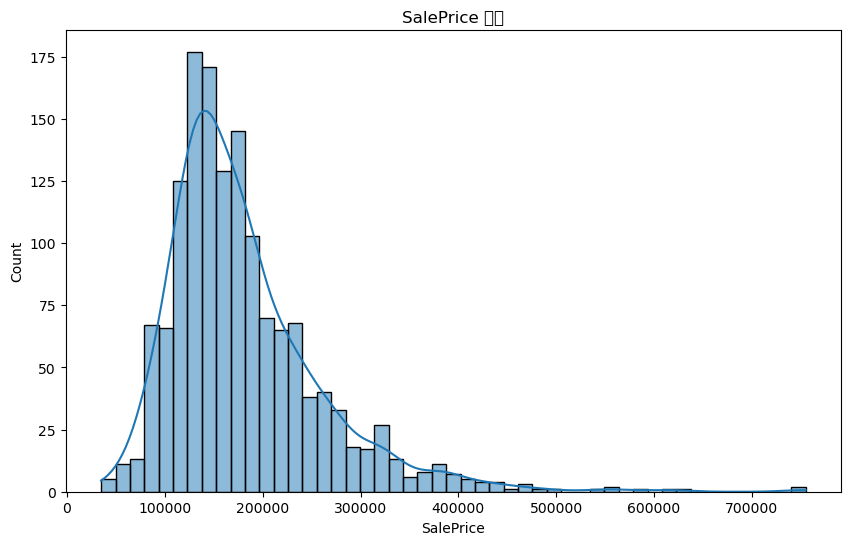


훈련 데이터 결측치 수:
PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageCond        81
GarageType        81
GarageFinish      81
GarageQual        81
BsmtFinType2      38
BsmtExposure      38
BsmtQual          37
BsmtCond          37
BsmtFinType1      37
MasVnrArea         8
Electrical         1
Id                 0
dtype: int64

수치형 변수 개수: 36
범주형 변수 개수: 43


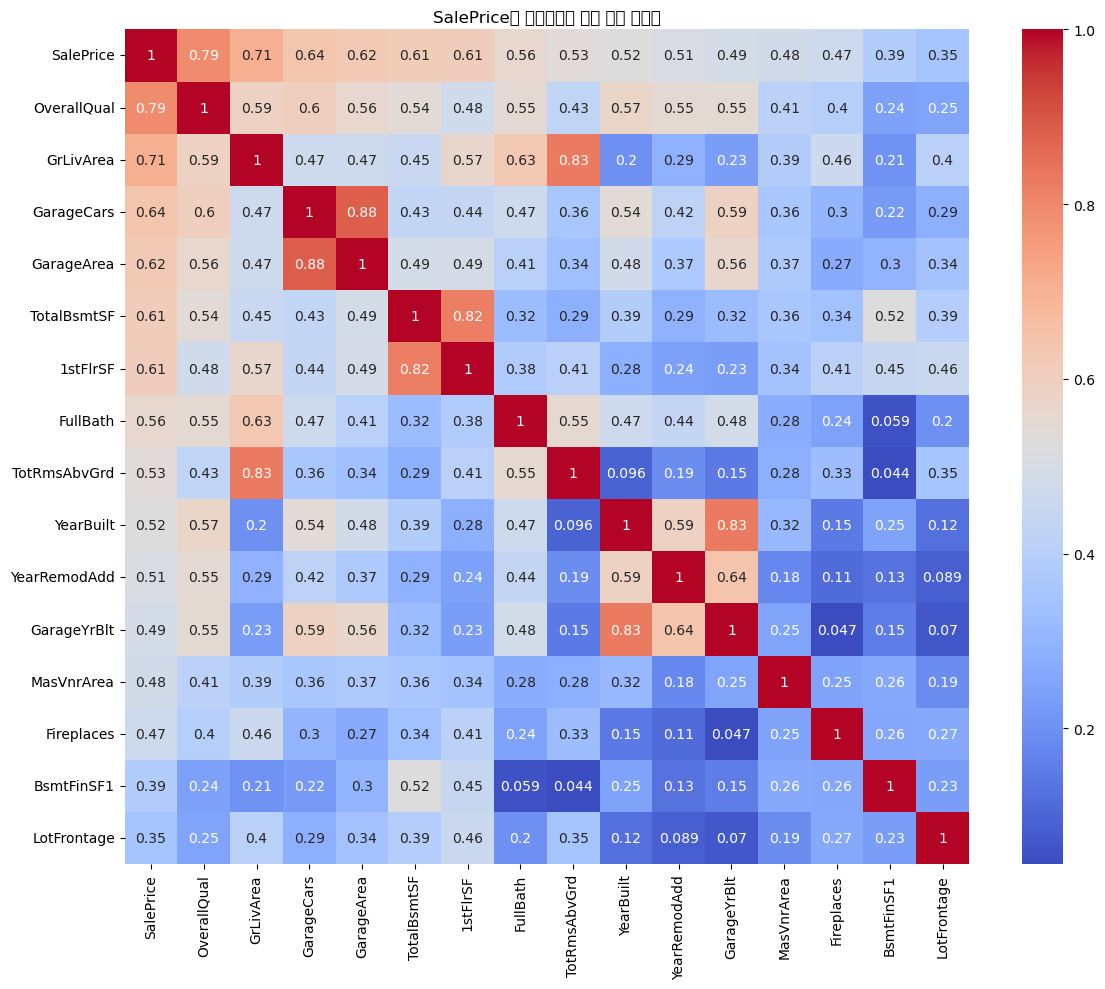


전처리 후 훈련 데이터 형태: (1460, 244)
전처리 후 테스트 데이터 형태: (1459, 244)

모델 평가 결과:
LinearRegression - RMSE: $26278.47, R^2: 0.9100
Ridge - RMSE: $25517.73, R^2: 0.9151
Lasso - RMSE: $26058.89, R^2: 0.9115


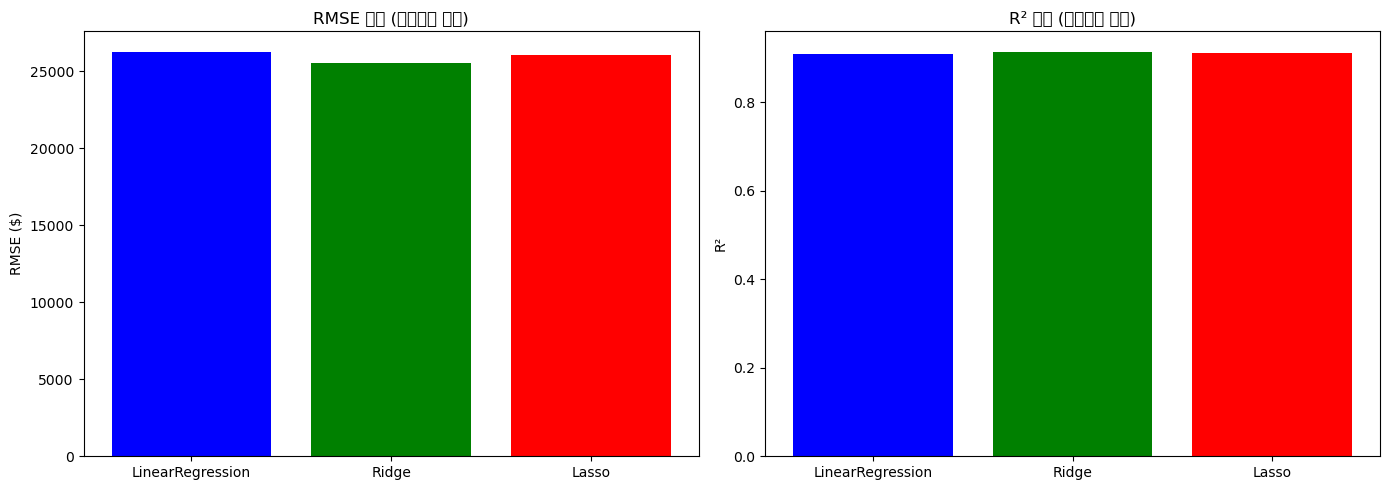


최적 모델: Ridge

예측 결과 저장 완료 (submission.csv)


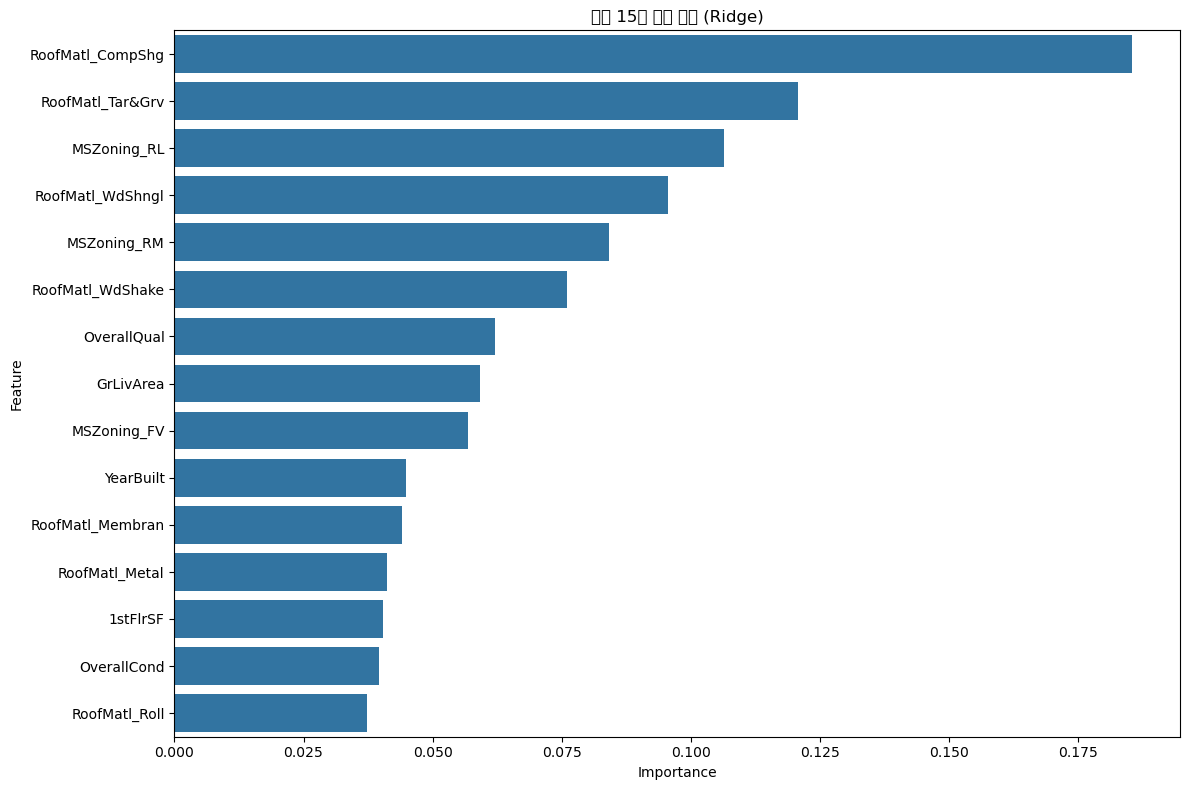

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# 데이터 로드
try:
    train_data = pd.read_csv('c:/temp/train(6).csv')
    test_data = pd.read_csv('c:/temp/test(6).csv')
    
    print("훈련 데이터 형태:", train_data.shape)
    print("테스트 데이터 형태:", test_data.shape)
    
    # 데이터 미리보기
    print("\n훈련 데이터 미리보기:")
    print(train_data.head())
    
    # 타겟 변수(SalePrice) 확인
    print("\n타겟 변수 기본 통계:")
    print(train_data['SalePrice'].describe())
    
    # 타겟 변수 분포 시각화
    plt.figure(figsize=(10, 6))
    sns.histplot(train_data['SalePrice'], kde=True)
    plt.title('SalePrice 분포')
    plt.show()
    
    # 결측치 확인
    print("\n훈련 데이터 결측치 수:")
    print(train_data.isnull().sum().sort_values(ascending=False)[:20])  # 상위 20개만 출력
    
    # 수치형 변수와 범주형 변수 분리
    numerical_features = train_data.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = train_data.select_dtypes(include=['object']).columns.tolist()
    
    numerical_features.remove('SalePrice')  # 타겟 변수 제외
    numerical_features.remove('Id')  # Id 제외
    
    print("\n수치형 변수 개수:", len(numerical_features))
    print("범주형 변수 개수:", len(categorical_features))
    
    # 상관관계 분석 (수치형 변수)
    correlation = train_data[numerical_features + ['SalePrice']].corr()
    plt.figure(figsize=(12, 10))
    # SalePrice와의 상관관계가 높은 상위 15개 변수만 선택
    top_features = correlation['SalePrice'].sort_values(ascending=False)[:16].index
    top_corr = train_data[top_features].corr()
    sns.heatmap(top_corr, annot=True, cmap='coolwarm')
    plt.title('SalePrice와 상관관계가 높은 상위 변수들')
    plt.tight_layout()
    plt.show()
    
    # 데이터 전처리 함수 정의
    def preprocess_data(train, test):
        # 훈련 세트와 테스트 세트 결합 (레이블 제외)
        train_id = train['Id'].copy()
        test_id = test['Id'].copy()
        y_train = train['SalePrice'].copy()
        
        train = train.drop(['Id', 'SalePrice'], axis=1)
        test = test.drop(['Id'], axis=1)
        
        # 수치형 변수와 범주형 변수 분리 (다시 정의)
        num_features = train.select_dtypes(include=['int64', 'float64']).columns.tolist()
        cat_features = train.select_dtypes(include=['object']).columns.tolist()
        
        # 모든 데이터 합치기 (전처리 용이성을 위해)
        all_data = pd.concat([train, test], axis=0)
        
        # 결측치 처리
        # 수치형 변수는 중앙값으로 대체
        for col in num_features:
            if col in all_data.columns:
                all_data[col] = all_data[col].fillna(all_data[col].median())
        
        # 범주형 변수는 최빈값으로 대체
        for col in cat_features:
            if col in all_data.columns:
                all_data[col] = all_data[col].fillna(all_data[col].mode()[0])
        
        # 범주형 변수 원-핫 인코딩
        all_data = pd.get_dummies(all_data, drop_first=True)
        
        # 다시 훈련 세트와 테스트 세트 분리
        train_processed = all_data[:len(train)]
        test_processed = all_data[len(train):]
        
        return train_processed, test_processed, y_train, train_id, test_id
    
    # 데이터 전처리 수행
    processed_train, processed_test, y_train, train_id, test_id = preprocess_data(train_data.copy(), test_data.copy())
    
    print("\n전처리 후 훈련 데이터 형태:", processed_train.shape)
    print("전처리 후 테스트 데이터 형태:", processed_test.shape)
    
    # 훈련 데이터를 훈련 세트와 검증 세트로 분할
    X_train, X_val, y_train_split, y_val = train_test_split(
        processed_train, y_train, test_size=0.2, random_state=42
    )
    
    # 표준화 (특성 스케일링)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    processed_test_scaled = scaler.transform(processed_test)
    
    # 타겟 변수 변환 (로그 변환 - 정규분포에 가깝게)
    y_train_log = np.log1p(y_train_split)
    y_val_log = np.log1p(y_val)
    
    # 1. LinearRegression 모델
    lr = LinearRegression()
    lr.fit(X_train_scaled, y_train_log)
    y_pred_lr = lr.predict(X_val_scaled)
    y_pred_lr = np.expm1(y_pred_lr)  # 역변환
    
    # 2. Ridge 모델 (L2 규제)
    ridge = Ridge(alpha=10)
    ridge.fit(X_train_scaled, y_train_log)
    y_pred_ridge = ridge.predict(X_val_scaled)
    y_pred_ridge = np.expm1(y_pred_ridge)  # 역변환
    
    # 3. Lasso 모델 (L1 규제)
    lasso = Lasso(alpha=0.001)
    lasso.fit(X_train_scaled, y_train_log)
    y_pred_lasso = lasso.predict(X_val_scaled)
    y_pred_lasso = np.expm1(y_pred_lasso)  # 역변환
    
except Exception as e:
    print(f"오류 발생: {e}")
    print("오류 위치 추적:")
    import traceback
    traceback.print_exc()

# 모델 평가 (RMSE, R^2)
def evaluate_model(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - RMSE: ${rmse:.2f}, R^2: {r2:.4f}")
    return rmse, r2

print("\n모델 평가 결과:")
rmse_lr, r2_lr = evaluate_model(y_val, y_pred_lr, "LinearRegression")
rmse_ridge, r2_ridge = evaluate_model(y_val, y_pred_ridge, "Ridge")
rmse_lasso, r2_lasso = evaluate_model(y_val, y_pred_lasso, "Lasso")

# 모델 비교 시각화
models = ['LinearRegression', 'Ridge', 'Lasso']
rmse_scores = [rmse_lr, rmse_ridge, rmse_lasso]
r2_scores = [r2_lr, r2_ridge, r2_lasso]

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.bar(models, rmse_scores, color=['blue', 'green', 'red'])
plt.title('RMSE 비교 (낮을수록 좋음)')
plt.ylabel('RMSE ($)')

plt.subplot(1, 2, 2)
plt.bar(models, r2_scores, color=['blue', 'green', 'red'])
plt.title('R² 비교 (높을수록 좋음)')
plt.ylabel('R²')

plt.tight_layout()
plt.show()

# 최종 모델 선택 (성능이 가장 좋은 모델로 선택)
best_model_idx = np.argmin(rmse_scores)
best_model_name = models[best_model_idx]
print(f"\n최적 모델: {best_model_name}")

# 최종 모델 선택과 테스트 세트 예측
if best_model_name == 'LinearRegression':
    final_model = LinearRegression()
elif best_model_name == 'Ridge':
    final_model = Ridge(alpha=10)
else:  # Lasso
    final_model = Lasso(alpha=0.001)

# 모든 훈련 데이터로 최종 모델 훈련
X_full_scaled = scaler.fit_transform(processed_train)
y_full_log = np.log1p(y_train)
final_model.fit(X_full_scaled, y_full_log)

# 테스트 세트 예측
test_preds = final_model.predict(processed_test_scaled)
test_preds = np.expm1(test_preds)  # 역변환

# 제출 파일 생성
submission = pd.DataFrame({
    'Id': test_id,
    'SalePrice': test_preds
})
submission.to_csv('submission.csv', index=False)
print("\n예측 결과 저장 완료 (submission.csv)")

# 중요 특성 시각화 (Ridge와 Lasso는 가능)
if best_model_name in ['Ridge', 'Lasso']:
    feature_importance = pd.DataFrame({
        'Feature': processed_train.columns,
        'Importance': np.abs(final_model.coef_)
    })
    
    top_features = feature_importance.sort_values('Importance', ascending=False).head(15)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=top_features)
    plt.title(f'상위 15개 중요 특성 ({best_model_name})')
    plt.tight_layout()
    plt.show()

데이터셋 정보:
특성 수: 8
샘플 수: 20640
특성 이름: MedInc, HouseAge, AveRooms, AveBedrms, Population, AveOccup, Latitude, Longitude

훈련 데이터: 14448 샘플
검증 데이터: 3096 샘플
테스트 데이터: 3096 샘플

----- 회귀 트리 모델 학습 -----
결정 트리 - 검증 RMSE: 0.6488, R²: 0.6769
랜덤 포레스트 - 검증 RMSE: 0.5234, R²: 0.7897
그래디언트 부스팅 - 검증 RMSE: 0.5011, R²: 0.8072
선형 회귀 - 검증 RMSE: 0.7354, R²: 0.5848

----- 모델 예측 결과 혼합 -----
가중치 - 결정 트리: 0.2368, 랜덤 포레스트: 0.2763, 그래디언트 부스팅: 0.2824, 선형 회귀: 0.2046
가중 평균 앙상블 - 검증 RMSE: 0.5389, R²: 0.7771

----- 스태킹 앙상블 모델 -----
스태킹 앙상블 - 검증 RMSE: 0.4967, R²: 0.8107

----- 최종 테스트 성능 평가 -----
결정 트리 - 테스트 RMSE: 0.6405, R²: 0.6898
랜덤 포레스트 - 테스트 RMSE: 0.4964, R²: 0.8136
그래디언트 부스팅 - 테스트 RMSE: 0.4725, R²: 0.8311
선형 회귀 - 테스트 RMSE: 0.7213, R²: 0.6066
가중 평균 앙상블 - 테스트 RMSE: 0.5083, R²: 0.8046
스태킹 앙상블 - 테스트 RMSE: 0.4692, R²: 0.8335


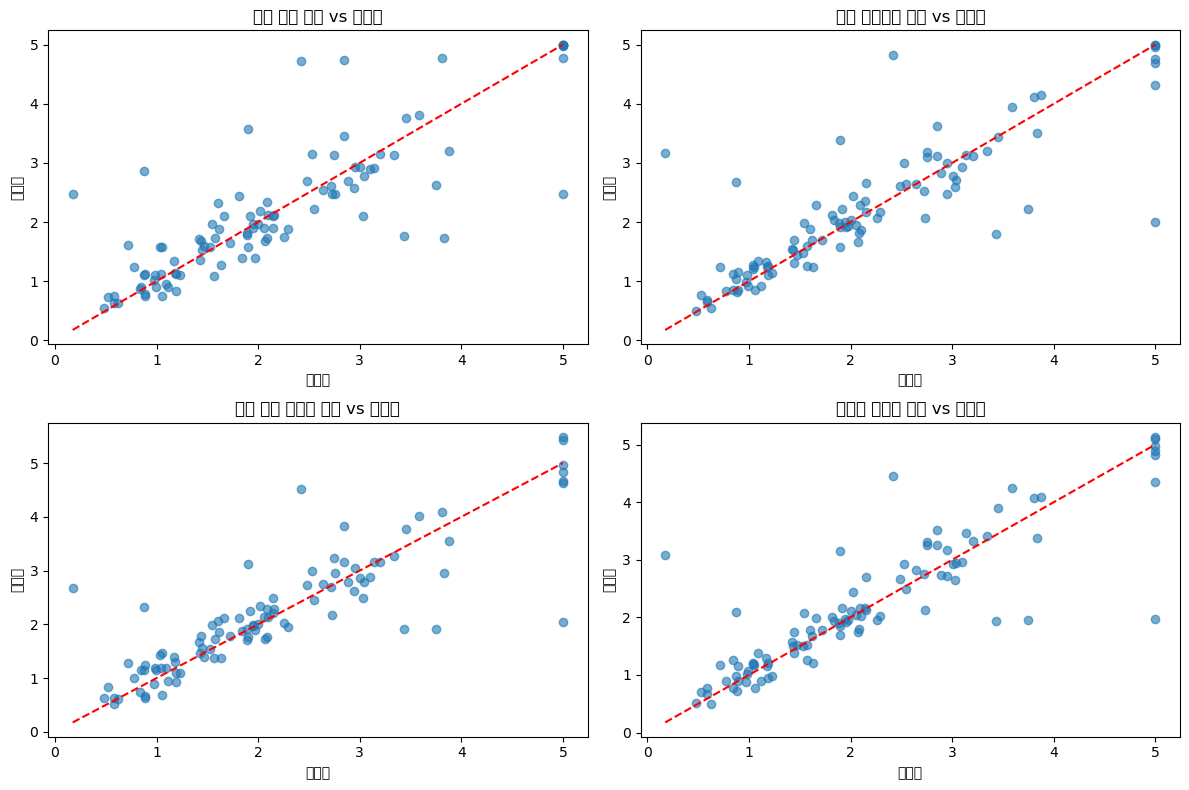

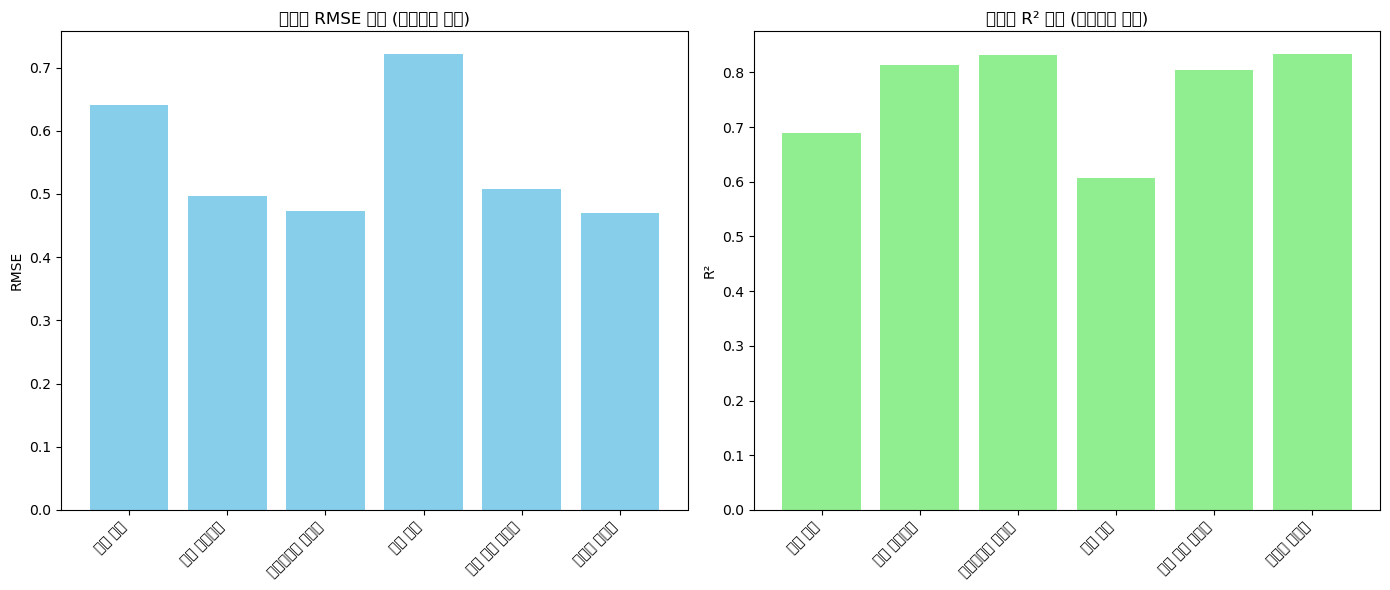


----- 결론 -----
테스트 데이터에서 가장 성능이 좋은 모델: 스태킹 앙상블
RMSE: 0.4692, R²: 0.8335


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingRegressor

# 데이터 로드 (캘리포니아 주택 가격 데이터셋)
housing = fetch_california_housing()
X = pd.DataFrame(housing.data, columns=housing.feature_names)
y = housing.target

print("데이터셋 정보:")
print(f"특성 수: {X.shape[1]}")
print(f"샘플 수: {X.shape[0]}")
print(f"특성 이름: {', '.join(housing.feature_names)}")

# 데이터 분할 (훈련, 검증, 테스트)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"\n훈련 데이터: {X_train.shape[0]} 샘플")
print(f"검증 데이터: {X_val.shape[0]} 샘플")
print(f"테스트 데이터: {X_test.shape[0]} 샘플")

# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# 1. 회귀 트리 모델 학습
print("\n----- 회귀 트리 모델 학습 -----")

# 결정 트리 회귀 모델
dt_regressor = DecisionTreeRegressor(max_depth=10, random_state=42)
dt_regressor.fit(X_train_scaled, y_train)
dt_val_pred = dt_regressor.predict(X_val_scaled)
dt_rmse = np.sqrt(mean_squared_error(y_val, dt_val_pred))
dt_r2 = r2_score(y_val, dt_val_pred)
print(f"결정 트리 - 검증 RMSE: {dt_rmse:.4f}, R²: {dt_r2:.4f}")

# 랜덤 포레스트 회귀 모델
rf_regressor = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
rf_regressor.fit(X_train_scaled, y_train)
rf_val_pred = rf_regressor.predict(X_val_scaled)
rf_rmse = np.sqrt(mean_squared_error(y_val, rf_val_pred))
rf_r2 = r2_score(y_val, rf_val_pred)
print(f"랜덤 포레스트 - 검증 RMSE: {rf_rmse:.4f}, R²: {rf_r2:.4f}")

# 그래디언트 부스팅 회귀 모델
gb_regressor = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb_regressor.fit(X_train_scaled, y_train)
gb_val_pred = gb_regressor.predict(X_val_scaled)
gb_rmse = np.sqrt(mean_squared_error(y_val, gb_val_pred))
gb_r2 = r2_score(y_val, gb_val_pred)
print(f"그래디언트 부스팅 - 검증 RMSE: {gb_rmse:.4f}, R²: {gb_r2:.4f}")

# 선형 회귀 모델 (비교용)
lr_regressor = LinearRegression()
lr_regressor.fit(X_train_scaled, y_train)
lr_val_pred = lr_regressor.predict(X_val_scaled)
lr_rmse = np.sqrt(mean_squared_error(y_val, lr_val_pred))
lr_r2 = r2_score(y_val, lr_val_pred)
print(f"선형 회귀 - 검증 RMSE: {lr_rmse:.4f}, R²: {lr_r2:.4f}")

# 2. 모델 예측 결과 혼합 (가중 평균)
print("\n----- 모델 예측 결과 혼합 -----")

# 개별 모델 가중치 결정 (검증 성능 기반)
total_r2 = dt_r2 + rf_r2 + gb_r2 + lr_r2
dt_weight = dt_r2 / total_r2
rf_weight = rf_r2 / total_r2
gb_weight = gb_r2 / total_r2
lr_weight = lr_r2 / total_r2

print(f"가중치 - 결정 트리: {dt_weight:.4f}, 랜덤 포레스트: {rf_weight:.4f}, "
      f"그래디언트 부스팅: {gb_weight:.4f}, 선형 회귀: {lr_weight:.4f}")

# 가중 평균 앙상블
ensemble_val_pred = (dt_weight * dt_val_pred + 
                     rf_weight * rf_val_pred + 
                     gb_weight * gb_val_pred +
                     lr_weight * lr_val_pred)

ensemble_rmse = np.sqrt(mean_squared_error(y_val, ensemble_val_pred))
ensemble_r2 = r2_score(y_val, ensemble_val_pred)
print(f"가중 평균 앙상블 - 검증 RMSE: {ensemble_rmse:.4f}, R²: {ensemble_r2:.4f}")

# 3. 스태킹 앙상블 학습
print("\n----- 스태킹 앙상블 모델 -----")

# 레벨-1 모델 정의
estimators = [
    ('dt', DecisionTreeRegressor(max_depth=10, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)),
    ('gb', GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)),
    ('lr', LinearRegression())
]

# 레벨-2 모델 (메타 모델) 정의
ridge = Ridge(alpha=1.0)

# 스태킹 앙상블 모델 생성
stacking_regressor = StackingRegressor(
    estimators=estimators,
    final_estimator=ridge,
    cv=5  # 5-fold 교차 검증
)

# 스태킹 모델 학습
stacking_regressor.fit(X_train_scaled, y_train)

# 스태킹 모델 검증
stacking_val_pred = stacking_regressor.predict(X_val_scaled)
stacking_rmse = np.sqrt(mean_squared_error(y_val, stacking_val_pred))
stacking_r2 = r2_score(y_val, stacking_val_pred)
print(f"스태킹 앙상블 - 검증 RMSE: {stacking_rmse:.4f}, R²: {stacking_r2:.4f}")

# 4. 최종 테스트 성능 평가
print("\n----- 최종 테스트 성능 평가 -----")

# 개별 모델 테스트
dt_test_pred = dt_regressor.predict(X_test_scaled)
rf_test_pred = rf_regressor.predict(X_test_scaled)
gb_test_pred = gb_regressor.predict(X_test_scaled)
lr_test_pred = lr_regressor.predict(X_test_scaled)

print(f"결정 트리 - 테스트 RMSE: {np.sqrt(mean_squared_error(y_test, dt_test_pred)):.4f}, R²: {r2_score(y_test, dt_test_pred):.4f}")
print(f"랜덤 포레스트 - 테스트 RMSE: {np.sqrt(mean_squared_error(y_test, rf_test_pred)):.4f}, R²: {r2_score(y_test, rf_test_pred):.4f}")
print(f"그래디언트 부스팅 - 테스트 RMSE: {np.sqrt(mean_squared_error(y_test, gb_test_pred)):.4f}, R²: {r2_score(y_test, gb_test_pred):.4f}")
print(f"선형 회귀 - 테스트 RMSE: {np.sqrt(mean_squared_error(y_test, lr_test_pred)):.4f}, R²: {r2_score(y_test, lr_test_pred):.4f}")

# 가중 평균 앙상블 테스트
ensemble_test_pred = (dt_weight * dt_test_pred + 
                     rf_weight * rf_test_pred + 
                     gb_weight * gb_test_pred +
                     lr_weight * lr_test_pred)
print(f"가중 평균 앙상블 - 테스트 RMSE: {np.sqrt(mean_squared_error(y_test, ensemble_test_pred)):.4f}, R²: {r2_score(y_test, ensemble_test_pred):.4f}")

# 스태킹 앙상블 테스트
stacking_test_pred = stacking_regressor.predict(X_test_scaled)
print(f"스태킹 앙상블 - 테스트 RMSE: {np.sqrt(mean_squared_error(y_test, stacking_test_pred)):.4f}, R²: {r2_score(y_test, stacking_test_pred):.4f}")

# 5. 모델별 예측 시각화
plt.figure(figsize=(12, 8))

# 예측값과 실제값 비교 (테스트 데이터의 일부만 사용)
sample_size = 100
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)

plt.subplot(2, 2, 1)
plt.scatter(y_test[sample_indices], dt_test_pred[sample_indices], alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('결정 트리 예측 vs 실제값')
plt.xlabel('실제값')
plt.ylabel('예측값')

plt.subplot(2, 2, 2)
plt.scatter(y_test[sample_indices], rf_test_pred[sample_indices], alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('랜덤 포레스트 예측 vs 실제값')
plt.xlabel('실제값')
plt.ylabel('예측값')

plt.subplot(2, 2, 3)
plt.scatter(y_test[sample_indices], ensemble_test_pred[sample_indices], alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('가중 평균 앙상블 예측 vs 실제값')
plt.xlabel('실제값')
plt.ylabel('예측값')

plt.subplot(2, 2, 4)
plt.scatter(y_test[sample_indices], stacking_test_pred[sample_indices], alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
plt.title('스태킹 앙상블 예측 vs 실제값')
plt.xlabel('실제값')
plt.ylabel('예측값')

plt.tight_layout()
plt.show()

# 6. 모델별 성능 비교 (막대 그래프)
models = ['결정 트리', '랜덤 포레스트', '그래디언트 부스팅', '선형 회귀', '가중 평균 앙상블', '스태킹 앙상블']
rmse_values = [
    np.sqrt(mean_squared_error(y_test, dt_test_pred)),
    np.sqrt(mean_squared_error(y_test, rf_test_pred)),
    np.sqrt(mean_squared_error(y_test, gb_test_pred)),
    np.sqrt(mean_squared_error(y_test, lr_test_pred)),
    np.sqrt(mean_squared_error(y_test, ensemble_test_pred)),
    np.sqrt(mean_squared_error(y_test, stacking_test_pred))
]
r2_values = [
    r2_score(y_test, dt_test_pred),
    r2_score(y_test, rf_test_pred),
    r2_score(y_test, gb_test_pred),
    r2_score(y_test, lr_test_pred),
    r2_score(y_test, ensemble_test_pred),
    r2_score(y_test, stacking_test_pred)
]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.bar(models, rmse_values, color='skyblue')
plt.title('모델별 RMSE 비교 (낮을수록 좋음)')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')

plt.subplot(1, 2, 2)
plt.bar(models, r2_values, color='lightgreen')
plt.title('모델별 R² 비교 (높을수록 좋음)')
plt.ylabel('R²')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

print("\n----- 결론 -----")
best_model = models[np.argmin(rmse_values)]
print(f"테스트 데이터에서 가장 성능이 좋은 모델: {best_model}")
print(f"RMSE: {min(rmse_values):.4f}, R²: {max(r2_values):.4f}")